Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [2]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [6]:
from sklearn.linear_model import LinearRegression
X = data.drop('target', axis=1)
Y = data['target']


model = LinearRegression()
model.fit(X, Y)

for column, coef in zip(X.columns, model.coef_):
    print(column, coef)
    
print(model.intercept_)
### Your code is here

feature_1 0.9999999999999989
feature_2 1.9999999999999893
feature_3 3.000000000000008
feature_4 4.000000000000003
feature_5 4.999999999999994
feature_6 6.000000000000004
feature_7 6.9999999999999964
feature_8 8.000000000000014
feature_9 8.999999999999991
feature_10 10.0
4.373157038707117


Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [52]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])
print(initial_betas)

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
print(scalar_value)
scalar_value = (scalar_value - Y).values
print(scalar_value)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[5.24339854 4.9524118  6.16354431 6.05108987 4.70336585 6.97562576
 6.36645618 5.64371227 6.31215445 6.13559383 5.57902419 5.32294422
 6.54997113 4.38646272 6.46648432 5.15761811 5.54622922 5.92460189
 6.49512761 5.20534235 4.79440676 4.64754149 4.3861493  6.28347287
 5.63170572 4.82066088 6.70447535 6.00305454 6.18649487 5.32348734
 6.37919592 6.30162516 5.73808802 5.58758426 6.64623264 4.92151158
 6.52622189 5.56147026 4.64504638 6.78092671 5.37963386 4.73847398
 5.56174807 6.42891712 6.33241798 5.92249654 5.00705898 5.96133463
 5.00952333 4.54853568 6.57722518 4.6827849  5.36082279 6.8455649
 5.66986831 7.65566972 5.363927   4.24811339 5.12653761 5.29553237
 5.10798391 5.87482995 6.62744705 5.99671407 5.75811197 5.45837844
 7.02034933 3.88183343 5.30169734 7.13075889 7.25145428 6.46300566
 6.09670393 4.39861176 5.45886785 5.42007817 7.14577431 6.96881144
 6.27359872 5.32991041 7.64957318 6.67765577 5.74732862 6.47829417
 6.92707771 6.91747901 4.200

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [53]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]
print(d_i1)
### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1
print(scalar_value)

[1.13768107e-01 3.80048040e-01 7.68461926e-01 6.06636831e-01
 1.19769781e-01 7.09440561e-01 3.51070785e-01 4.07922933e-01
 9.09109388e-01 8.97732978e-01 1.14523274e-01 4.03444426e-01
 7.03064154e-01 4.35740645e-01 8.67445323e-01 9.72333590e-01
 3.40524070e-01 2.43060008e-01 9.20653927e-01 6.09519384e-01
 6.12201542e-01 9.47261045e-01 6.93469199e-01 9.31654329e-01
 3.65458067e-01 6.57138773e-02 2.19818774e-01 6.31288910e-01
 6.68181416e-01 8.33952273e-01 8.34089419e-01 7.08499500e-01
 3.14640327e-01 8.48615480e-01 1.77080539e-01 8.31700751e-01
 8.02500274e-01 5.75984316e-01 1.69205432e-01 7.39388183e-01
 9.50438497e-01 8.72836718e-01 4.46394800e-01 5.21557007e-01
 5.02629977e-01 8.45786923e-01 4.16636310e-01 7.73042667e-01
 6.55457633e-01 4.74001251e-03 7.19046697e-01 8.76527633e-02
 3.53890886e-01 7.86006553e-01 9.24538993e-01 3.89290872e-01
 2.87096541e-03 3.39381720e-01 9.71001252e-01 5.44160402e-01
 4.13041361e-01 1.39697621e-01 6.19772356e-01 4.92924368e-01
 8.53509604e-01 9.043761

In [9]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

In [72]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold=1e-6, copy: bool = True):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        ### Your code is here
        self.samples = samples
        self.targets = targets
        self.beta = np.ones(self.samples.shape[1])
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.iteration_loss_dict = dict()
        if copy:
            self.samples = samples.copy()
        else:
            self.samples = samples

    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        ### Your code is here
        self.samples['interсept'] = 1
        self.beta = np.ones(self.samples.shape[1])

    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки

        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        ### Your code is here
        scalar_value = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        scalar_value = (scalar_value - self.targets).values

        return (np.mean(scalar_value ** 2))

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.

        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        ### Your code is here
        result = []
        scalar_value = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        scalar_value = (scalar_value - self.targets).values
        ### Возьмем столбик со значениями 1 признака

        for i in range(len(self.samples.columns)):
            d_i1 = self.samples.values[:, i]

        ### Умножим каждый объект на соответствующее значение признака
            result_value = scalar_value * d_i1
            result = np.append(result, (2 * np.mean(result_value)))
        return result

    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        ### Your code is here
        self.beta = self.beta - self.learning_rate * (self.calculate_gradient())

    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict

        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| > threshold:
                Повторяем первые 3 шага

        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| > threshold:
                Повторяем первые 3 шага
        """
        ### Your code is here
        start_betas = self.beta
        previous_mse = self.calculate_mse_loss()
        self.iteration()
        next_mse = self.calculate_mse_loss()
        new_betas = self.beta
        while abs(np.linalg.norm(new_betas) - np.linalg.norm(start_betas)) > self.threshold:
            previous_mse = self.calculate_mse_loss()
            start_betas = self.beta
            self.iteration()
            new_betas = self.beta
            next_mse = self.calculate_mse_loss()
            self.iteration_loss_dict[len(self.iteration_loss_dict)] = next_mse
        """while abs(previous_mse - next_mse) > self.threshold:
            previous_mse = self.calculate_mse_loss()

            self.iteration()
            next_mse = self.calculate_mse_loss()
            self.iteration_loss_dict[len(self.iteration_loss_dict)] = next_mse"""

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [73]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [81]:
print(f'iteration_loss_dict:{list(GD.iteration_loss_dict.items())[-1:-3:-1]}')

iteration_loss_dict:[(77817, 3.1521824087166276e-05), (77816, 3.152638981145887e-05)]


In [76]:
print('Веса модели при переменных d1, d2, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d1, d2, ..., d10 равны соответственно: 

[0.99345747 1.99488524 2.99305591 3.99297981 4.99451635 5.99434133
 6.99446662 7.99530803 8.99328562 9.99211727 2.20210579 2.20210579]


Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [ ]:
### Your code is here

В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


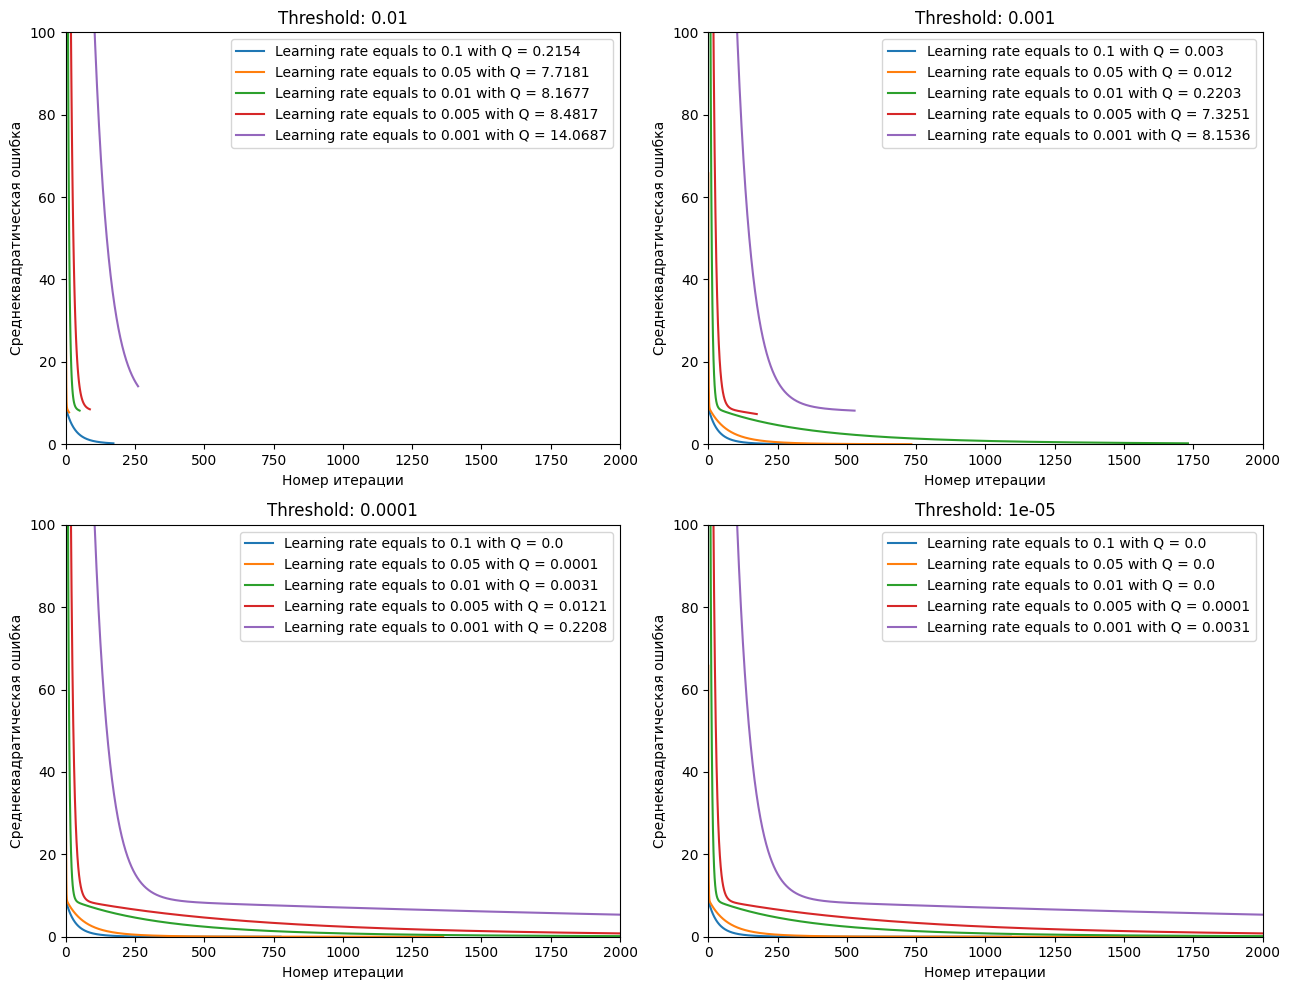

In [86]:
fig = plt.figure()

fig.set_size_inches(13, 10)

"""Задать списки для итераций"""
### Your code is here 
rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
thresholds = [1e-2, 1e-3, 1e-4, 1e-5]

for i in range(len(thresholds)):
    """Задать threshold, добавить график на полонто, создать список для хранения значений функционала"""
    ### Your code is here
    Q_values = []
    threshold = thresholds[i]
    ax = plt.subplot(2, 2, i+1) # делим полотно на части, определяем начало первой части
    for lr in rates:
        """Создать объект модели, добавить константу, запустить обучение модели"""
        ### Your code is here
        GD = GradientDescentMse(samples=X, targets=Y, learning_rate=lr, threshold=threshold)
        GD.add_constant_feature()
        GD.learn()
        """Определить learning_path через атрибут iteration_loss_dict"""
        ### Your code is here
        learning_path = GD.iteration_loss_dict
        """Отобразить learning_path на графике"""
        ### Your code is here
        plt.ylim(0, 100)
        plt.xlim(0, 2000)
        plt.plot(learning_path.keys(), learning_path.values())
        Q_values.append(str(round(list(learning_path.values())[-1], ndigits=4)))
    
    ax.set_title(f'Threshold: {threshold}') 
    plt.ylabel('Среднеквадратическая ошибка')
    plt.xlabel('Номер итерации')
    plt.legend([f'Learning rate equals to {rates[i]}' + ' with Q = ' + Q_values[i] for i in range(len(rates))])

fig.tight_layout() 

plt.show()